In [3]:
pip install comet_ml

Note: you may need to restart the kernel to use updated packages.


In [4]:

#importamos comet e iniciamos el proyecto (pedira tu api key)
import comet_ml
comet_ml.init(project_name="Temperaturas")
filepath='Beste_model1.hdf5'
#descargamos datos
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)


Comet API key:  ············································


COMET ERROR: Invalid Comet API key for https://www.comet.com/clientlib/
Please see https://www.comet.com/docs/command-line/#comet-check for more information.
Use: comet_ml.init() to try again


--2023-11-03 15:58:18--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.108.72, 52.217.100.22, 52.216.146.133, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.108.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  65.8MB/s    in 0.2s    

2023-11-03 15:58:18 (65.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [89]:
#Definimos un nuevo experimento en comet
experiment = comet_ml.Experiment(
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
    log_code=True,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/efrenct/temperaturas/5c21f9ff493e4d768acd306cfe39253c



In [25]:
#abrimos nuestra base de datos del archivo .csv, y lo renombramos com f. despues leemos los datos y creamos una lista 
#llamada lista donde cadad elemento se separa con el metodo.split("caracter que se identifica para separar")
#y de esta lista separamoe el primer elemento que contiene los nombres de las columnas de los datos
import tensorflow as tf
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
%matplotlib inline
plt.style.use('default')

import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical

import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
   data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(lines[0])
print('linea es del tipo:',type(lines))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
linea es del tipo: <class 'list'>
420451


In [6]:
#Primerose creamos dos arreglos no el primero llamad temperatura, para alamacenar los datos de la temperaturea que hay enla
#la base de datos, y la otra llamda raw_data que contiene los demas datos contenidos en lines
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
print(temperature.shape)
#Ahora convertimos todos los valores de la lista lines en flotantes, para evitar futuros problemas se hace elemento por elemento
#en cada elemento de lines y para saber cuales elementos son se usa nuevemanete el metodo split en cada elemento de lines
#pero ahora se se para cuando se encuentre una coma 

#Una vez que ya se conviertio un elemenot de lines en una llista (values) con numeros flotantes, extraemos el segundo elemento 
#de estas listas pues es el que pertenece a la temperatura, y los demas los guardamos en raw_data(el elemento 0 o primero de values
#es la fecha asi este dano no nos interesa por ahora).
for i, line in enumerate(lines): #este ciclo crea un indice 1 que "etiqueta a un elemento de lines conforme avanza el ciclo"
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]
print((raw_data.shape))
print((temperature.shape))
print((raw_data[0]))
print((temperature[0]))

(420451,)
(420451, 14)
(420451,)
[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
-8.02


In [52]:
#generamos las secuencias para predecir 10 datos
sequence_legth=120
data_predict=10
prediccion=[]
ta=[]
for i in range(len(temperature[sequence_legth:len(temperature)-data_predict+1])):
    ta=[]
    for n in range(10):
        ta.append(temperature[i+120+n])
    prediccion.append(ta)


In [7]:
prediccion=np.array(prediccion)

In [8]:
from tensorflow import keras
import numpy as np
int_sequence = np.arange(10) #Generamos un array de enteros del 0 al 9
sequence_length=120
data_predict=1
#datos para predecir la temperatura
dataset = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-data_predict],    #secuencia para valores de x
    targets=temperature[sequence_length:],#secuencia para extraer los valores y
    #shuffle=True,
    sequence_length=sequence_length,  #tamano de las secuencias x
    #start_index=1,
    end_index=210220,
    batch_size=100,  #cada vez que se llame "dataset" nos regresara un batch de 2 secuencias
)

val_data = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-data_predict],    #secuencia para valores de x
    targets=temperature[sequence_length:],#secuencia para extraer los valores y
    shuffle=True,
    sequence_length=sequence_length,  #tamano de las secuencias x
    start_index=210220,
    end_index=315330,
    batch_size=100,  #cada vez que se llame "dataset" nos regresara un batch de 2 secuencias
)
test_data = keras.utils.timeseries_dataset_from_array(
    data=temperature[:-data_predict],    #secuencia para valores de x
    targets=temperature[sequence_length:],#secuencia para extraer los valores y
    shuffle=True,
    sequence_length=sequence_length,  #tamano de las secuencias x
    start_index=315330,
    #end_index=,
    batch_size=1,  #cada vez que se llame "dataset" nos regresara un batch de 2 secuencias
)

In [61]:
#"resto de datos para predecir la temperatura"
dataset2 = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-data_predict], #notar que ahora la serie en x son las demás columnas de los datos
    targets=temperature[sequence_length:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=100,
    end_index=210220
    )
val_data2 = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-data_predict],
    targets=temperature[sequence_length:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=100,
    start_index=210220,
    end_index=315330,
    )
test_data2 = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-data_predict],    #secuencia para valores de x
    targets=temperature[sequence_length:],#secuencia para extraer los valores y
    shuffle=True,
    sequence_length=sequence_length,  #tamano de las secuencias x
    start_index=315330,
    #end_index=,
    batch_size=1,  #cada vez que se llame "dataset" nos regresara un batch de 2 secuencias
)

In [94]:

from keras.layers import LSTM

def slice(x, slice_length):
    return x[:,-slice_length:,:]

model1 = Sequential()
ks=15
model1.add(LSTM(220,return_sequences=True,batch_input_shape=(None, None, 1)))
model1.add(LSTM(80))
model1.add(Dense(60))
model1.add(Dense(10))
model1.add(Dense(1))

model1.summary()
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, None, 220)         195360    
                                                                 
 lstm_13 (LSTM)              (None, 80)                96320     
                                                                 
 dense_31 (Dense)            (None, 60)                4860      
                                                                 
 dense_32 (Dense)            (None, 10)                610       
                                                                 
 dense_33 (Dense)            (None, 1)                 11        
                                                                 
Total params: 297,161
Trainable params: 297,161
Non-trainable params: 0
_________________________________________________________________


In [95]:
history1 = model1.fit(dataset,
                    epochs=50,
                    validation_data=val_data,
                    verbose=1,
                    callbacks=[checkpoint])

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/50
2101/2102 [============================>.] - ETA: 0s - loss: 0.5449
Epoch 1: val_loss improved from inf to 0.34146, saving model to Beste_model1.hdf5
2102/2102 [==============================] - 72s 32ms/step - loss: 0.5449 - val_loss: 0.3415
Epoch 2/50
2102/2102 [==============================] - ETA: 0s - loss: 0.1093
Epoch 2: val_loss improved from 0.34146 to 0.14098, saving model to Beste_model1.hdf5
2102/2102 [==============================] - 67s 32ms/step - loss: 0.1093 - val_loss: 0.1410
Epoch 3/50
2102/2102 [==============================] - ETA: 0s - loss: 0.1078
Epoch 3: val_loss improved from 0.14098 to 0.06038, saving model to Beste_model1.hdf5
2102/2102 [==============================] - 68s 32ms/step - loss: 0.1078 - val_loss: 0.0604
Epoch 4/50
2101/2102 [============================>.] - ETA: 0s - loss: 0.0735
Epoch 4: val_loss did not improve from 0.06038
2102/2102 [==============================] - 67s 32ms/step - loss: 0.0735 - val_loss: 0.1012
Epoch 5/50


KeyboardInterrupt: 

In [96]:
#cargamos nuestro mejor modelo a comeet
experiment.log_model("Beste_model1.hdf5", filepath)

{'web': 'https://www.comet.com/api/asset/download?assetId=d1b7d10de457490dab30eab115263082&experimentKey=5c21f9ff493e4d768acd306cfe39253c',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d1b7d10de457490dab30eab115263082&experimentKey=5c21f9ff493e4d768acd306cfe39253c',
 'assetId': 'd1b7d10de457490dab30eab115263082'}

In [97]:
#terminamos el experimento.
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/efrenct/temperaturas/5c21f9ff493e4d768acd306cfe39253c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [6771]          : (0.006961567793041468, 29.61014747619629)
COMET INFO:     epoch_duration [32]        : (65.6100692759992, 71.42430037799932)
COMET INFO:     loss [32]                  : (0.05757680907845497, 0.5449204444885254)
COMET INFO:     val_loss [32]              : (0.04154599830508232, 0.3414563238620758)
COMET INFO:     validate_batch_loss [3360] : (0.029388463124632835, 0.3526957035064697)
COMET INFO:   Others:
COMET INFO:     trainable_params : 297161
COMET INFO:   Parameters:
COMET INFO:     Ad

In [45]:
#extraemos una secuencia para predecir, de los daotos de prueba
a=0
for sec,predi in test_data:
    if a==0:
        C=sec
        D=predi
        break
    a=a+1
print(C)
print(D)

tf.Tensor(
[[10.87 10.78 10.54 10.32 10.26 10.04  9.85  9.62  9.65  9.69  9.78  9.24
   8.91  8.61  8.34  8.33  8.63  8.64  8.63  8.66  8.46  8.48  8.7   8.75
   9.09  9.52  9.23  9.18  9.1   9.04  8.92  9.17  9.62  9.72  9.96 10.06
   9.69 10.13 10.16 10.43  9.8   9.55  9.46  9.29  9.33  9.46  9.54  9.68
  10.02 10.24 10.28 10.57 10.97 11.22 11.5  11.34 11.41 11.78 12.34 12.96
  13.59 13.72 14.14 14.63 15.11 15.45 15.23 15.93 17.34 17.84 17.87 17.82
  17.67 17.43 17.38 17.03 17.23 17.21 16.67 16.21 16.06 16.05 16.05 15.98
  15.67 15.25 14.86 13.86 13.22 12.38 11.67 11.43 11.43 11.29 11.07 10.89
  10.54 10.31 10.26 10.1  10.04 10.02 10.02 10.06 10.01 10.01 10.01 10.
   9.98  9.82  9.67  9.56  9.32  9.03  8.76  8.44  8.28  8.2   8.17  8.05]], shape=(1, 120), dtype=float64)
tf.Tensor([7.86], shape=(1,), dtype=float64)


In [10]:
model1=keras.models.load_model("/kaggle/input/modelo-entrenado/modelo_Temperatura.hdf5")

In [50]:
print(C)
model1.predict(C)

tf.Tensor(
[[10.87 10.78 10.54 10.32 10.26 10.04  9.85  9.62  9.65  9.69  9.78  9.24
   8.91  8.61  8.34  8.33  8.63  8.64  8.63  8.66  8.46  8.48  8.7   8.75
   9.09  9.52  9.23  9.18  9.1   9.04  8.92  9.17  9.62  9.72  9.96 10.06
   9.69 10.13 10.16 10.43  9.8   9.55  9.46  9.29  9.33  9.46  9.54  9.68
  10.02 10.24 10.28 10.57 10.97 11.22 11.5  11.34 11.41 11.78 12.34 12.96
  13.59 13.72 14.14 14.63 15.11 15.45 15.23 15.93 17.34 17.84 17.87 17.82
  17.67 17.43 17.38 17.03 17.23 17.21 16.67 16.21 16.06 16.05 16.05 15.98
  15.67 15.25 14.86 13.86 13.22 12.38 11.67 11.43 11.43 11.29 11.07 10.89
  10.54 10.31 10.26 10.1  10.04 10.02 10.02 10.06 10.01 10.01 10.01 10.
   9.98  9.82  9.67  9.56  9.32  9.03  8.76  8.44  8.28  8.2   8.17  8.05]], shape=(1, 120), dtype=float64)
1/1 [==============================] - 0s 23ms/step


array([[8.011304]], dtype=float32)

In [57]:
def predict_sequence(input_sequence, model, pred_steps):

    history_sequence = input_sequence
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)

    for i in range(pred_steps):

        # record next time step prediction (last time step of model output)
        last_step_pred = model.predict(history_sequence)[-120:]
        pred_sequence[0,i,0] = last_step_pred

        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence,
                                           last_step_pred], axis=1)

    return pred_sequence

In [58]:
predici=predict_sequence(C,model1,10)

1/1 [==============================] - 0s 23ms/step


In [59]:
print(predici)

[[[8.0113039 ]
  [8.04272461]
  [8.09177399]
  [8.14707375]
  [8.21544933]
  [8.29870033]
  [8.39882755]
  [8.51743889]
  [8.65585518]
  [8.81498814]]]


10


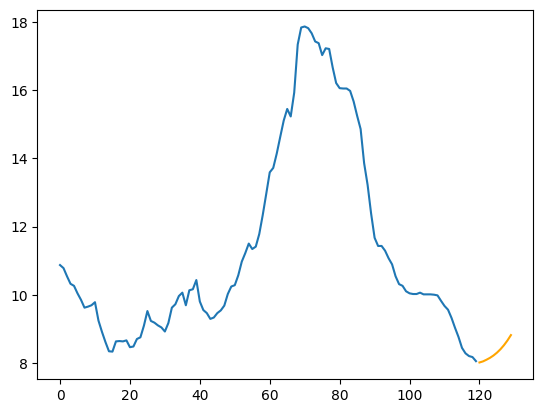

In [49]:

print(len(predici[0]))
plt.plot(range(len(C[0])),C[0])
plt.plot(range(len(C[0]),len(C[0])+len(predici[0])),predici[0],color='orange')

In [51]:
plt.savefig("datospredichos.png")

<Figure size 640x480 with 0 Axes>

In [62]:
#extraemos una secuencia para predecir, de los daotos de prueba
a=0
for sec,predi in test_data2:
    if a==0:
        A=sec
        B=predi
        break
    a=a+1
print(A)
print(B)

tf.Tensor(
[[[991.07   5.18 279.06 ...   1.4    2.52 186.5 ]
  [991.07   5.14 279.01 ...   1.47   2.24 194.4 ]
  [991.01   5.05 278.93 ...   1.31   1.76 198.9 ]
  ...
  [990.52   9.84 283.77 ...   1.68   4.   218.7 ]
  [990.6    9.86 283.79 ...   1.23   2.24 214.3 ]
  [990.61   9.86 283.78 ...   1.3    2.2  209.9 ]]], shape=(1, 120, 14), dtype=float64)
tf.Tensor([9.88], shape=(1,), dtype=float64)


In [63]:
model2=keras.models.load_model("/kaggle/input/modelo-otros-datos/Beste_model2.hdf5")

In [70]:
#prediccion con el modelo de los demas datos
print('la secuencia de los datos es la siguiente')
print(A)
print('\nla prediccion del modelo es:\n')
print(model2.predict(A))
print('\nla la temperatura correcta es:\n')
print(B)

la secuencia de los datos es la siguiente
tf.Tensor(
[[[991.07   5.18 279.06 ...   1.4    2.52 186.5 ]
  [991.07   5.14 279.01 ...   1.47   2.24 194.4 ]
  [991.01   5.05 278.93 ...   1.31   1.76 198.9 ]
  ...
  [990.52   9.84 283.77 ...   1.68   4.   218.7 ]
  [990.6    9.86 283.79 ...   1.23   2.24 214.3 ]
  [990.61   9.86 283.78 ...   1.3    2.2  209.9 ]]], shape=(1, 120, 14), dtype=float64)

la prediccion del modelo es:

1/1 [==============================] - 0s 22ms/step
[[9.773012]]

la la temperatura correcta es:

tf.Tensor([9.88], shape=(1,), dtype=float64)
